# Airline Delayes and cancellation 

## Introduction
In this project, we would like to make airline delay predictions for the airport JFK in New York. The aim is to use relevant variables to build models for predictions of departure delay in JFK airport. We will use two datasets for the analysis. The first dataset contains information of airline delays and cancellation and the second dataset contains information of weather.

The airline delay dataset consists of more than 6 million flight observations and 28 variables of which some are technical data on airlines, airports, flight numbers, and the rest are time-related. The dataset is from the year 2010.

The weather dataset consists of hourly weather observations for "Temperature" and "Windspeed", for the year 2010.

We will explore the airline delay dataset and look at relevant variables we can use for predictions of departure delay. Then we will use the variables to build a Baysesian linear regression models and neural network models in pyro.

## Data preprocess
### Airline delay dataset
The data is loaded from a csv file into a pandas dataframe object and preprocessed. We convert the date to a datetime and set as index. We remove nan values instead of imputing values since we have lots of observations and don't need more data. We have chosen to work with a subset of the data where we investigate the first six months of 2010. The reason behind this is to reduce the amount of data but also to have data recorded from different seasons (ie. winter, spring and summer).

In [1]:
########## Imports
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Read data
data = pd.read_csv('Data/2010.csv')

In [3]:
# Convert string to DateTime and set as index
data.FL_DATE = pd.to_datetime(data.FL_DATE, infer_datetime_format=True)
data.set_index('FL_DATE', inplace=True)
data.drop(columns='Unnamed: 27', axis=1, inplace=True) # Drop last weird column

# Drop NaN values in the variables we will use in our baseline model
data = data[data['TAXI_OUT'].notna()]
data = data[data['ORIGIN'].notna()]
data = data[data['DEST'].notna()]

# Take first 6 months
df = data.loc['2010-01-01':'2010-06-30']
# Renaming airline codes to company names
# Source: https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States

df['OP_CARRIER'].replace({
    'UA':'United Airlines',
    'AS':'Alaska Airlines',
    '9E':'Endeavor Air',
    'B6':'JetBlue Airways',
    'EV':'ExpressJet',
    'F9':'Frontier Airlines',
    'G4':'Allegiant Air',
    'HA':'Hawaiian Airlines',
    'MQ':'Envoy Air',
    'NK':'Spirit Airlines',
    'OH':'PSA Airlines',
    'OO':'SkyWest Airlines',
    'VX':'Virgin America',
    'WN':'Southwest Airlines',
    'YV':'Mesa Airline',
    'YX':'Republic Airways',
    'AA':'American Airlines',
    'DL':'Delta Airlines'
},inplace=True)

# Use only JFK
df = df[df.ORIGIN == 'JFK']

C:\Users\jonas\AppData\Local\Temp\ipykernel_204\739802548.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OP_CARRIER'].replace({


The two variables "DEP_TIME" and "DEP_DELAY" are time variables, and we change them both to appropriate datetime format. With this change we have exact information of flight takeoff and not just which day.

In [4]:
delays = df[['DEP_DELAY', 'DEP_TIME']]
delays['DEP_TIME'] = delays['DEP_TIME'].astype(int)

preps = []
for i in range(len(delays['DEP_TIME'])):
    # Zero fill values
    dep_time_val = str(delays['DEP_TIME'].iloc[i]).zfill(4)
    # If flight at 24:00, set that as 00:00
    if dep_time_val == str(2400):
        dep_time_act = datetime.datetime.strptime('0000','%H%M').strftime('%H:%M')
    else:
        dep_time_act = datetime.datetime.strptime(dep_time_val,'%H%M').strftime('%H:%M')
    

    # append
    preps.append(dep_time_act)

# Drop and add corrected times
df.drop(columns=['DEP_TIME'])
df['DEP_TIME'] = preps
df['DEP_TIME'] = pd.to_datetime(df['DEP_TIME'], format='%H:%M') # Convert to datetime

# Convert FL time to column
df = df.reset_index(level=0)

C:\Users\jonas\AppData\Local\Temp\ipykernel_204\2530428706.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delays['DEP_TIME'] = delays['DEP_TIME'].astype(int)


In [5]:
comb_date = []
# Loop through all to combine dates and time
for i in range(len(df['DEP_TIME'])):

    # Get date and time
    date = datetime.datetime.date(df['FL_DATE'].iloc[i])
    time = datetime.datetime.time(df['DEP_TIME'].iloc[i])

    # Get combined as a string
    comb = datetime.datetime.combine(date, time).strftime('%Y-%m-%d %H:%M:%S')

    #append
    comb_date.append(comb)


In [6]:
# Add column, and remove DEP_TIME and FL_DATE
df['DATE_TIME'] = pd.to_datetime(comb_date)
# Get dep time as time only
df['DEP_TIME'] = pd.to_datetime(df['DEP_TIME'], format='%H:%M').dt.time # Convert to datetime


In [7]:
# Move it to the front of the data frame
dates = df.pop('DATE_TIME')
df.insert(0, 'DATE_TIME', dates)


### Weather dataset
The weather data is loaded and only relevant features are extracted. In the dataset we use weather observations for the first six months of 2010 as the other dataset. 

In [8]:
# Load weather data
df_weather_all = pd.read_csv('Data/Weather.csv')
# Select only relevant features
df_weather = df_weather_all[["NAME","DATE","HLY-TEMP-NORMAL","HLY-WIND-AVGSPD"]]
# Select only JFK airport and from January 1st to July 1st
df_weather= df_weather[(df_weather["NAME"] == "JFK INTERNATIONAL AIRPORT, NY US") & (df_weather["DATE"] < '07-01T00:00:00')]
# Change the format of DATE to datetime
df_weather["DATE"] = pd.to_datetime(df_weather["DATE"],format='%m-%dT%H:%M:%S',infer_datetime_format='%d-%m-%H')
# Change the format to month - day - hour
df_weather["DATE"] = df_weather["DATE"].dt.strftime("%m-%d-%H")
# Change NAME to just JFK
df_weather["NAME"] = 'JFK'
# Reset index
df_weather = df_weather.reset_index().drop('index',axis=1)



In the dataset we have weather observation for each hour of the day, but in the airline dataset there are multiple flights each hour. Hence when we combine the two datasets we find weather observations corresponding to the hour in the airline dataset. 

In [9]:
# Select interesting features
df = df[["FL_DATE","OP_CARRIER","DEP_TIME","TAXI_OUT", "DEP_DELAY"]]

# Now we must merge df_weather and df
df["TEMP"] = 0
df["WIND"] = 0

# Go through all flights in data
for i in range(len(df)):
    # Filter out the month, day and hour 
    hour = df["DEP_TIME"][i].strftime("%H")
    monthday = df["FL_DATE"][i].strftime("%m-%d")
    
    # We don't have weather recording for first hour of January 1st 2010- therefore we skip these flights and continue
    if monthday+'-'+hour == '01-01-00':
        continue
    else:
        # Find temp in df_weather corresponding to month, day and hour
        df.iloc[i,-2] = df_weather[df_weather["DATE"] == monthday+'-'+hour].iloc[0,2]
        # Find wind in df_weather corresponding to month, day and hour
        df.iloc[i,-1] = df_weather[df_weather["DATE"] == monthday+'-'+hour].iloc[0,3]
        
# The hour of january 1st is not included in weather data. Therefore we drop the flights occurring in that time
df = df[df.TEMP > 0]

Måske vi skal have det her ind senere???

In [10]:
# Average delays
y = df.groupby('FL_DATE', as_index=False)['DEP_DELAY'].mean()
#df.set_index('FL_DATE', inplace=True)

In [11]:
# Impose delay from previous day
df["DELAY_PREV"] = 0
# Set index as date
# Loop
for i in range(len(y)):
    if y['FL_DATE'][i].strftime('%d') == '01':
        continue

    # Take date
    date = y['FL_DATE'][i].strftime('%Y-%m-%d')
    
    df.loc[df.FL_DATE == date, 'DELAY_PREV']= y['DEP_DELAY'][i-1]
    





The categorical variable "OP_CARRIER" (name of airline) is one hot encoded, in order to use it as an input feature in the regression model. 

In [12]:
# One hot encode the carriers
y = pd.get_dummies(df.OP_CARRIER, prefix='OP_CARRIER')
# Drop column as it is now encoded
df.drop(columns='OP_CARRIER', inplace=True)
# Join the encoded df
df = df.join(y)

The preprocesed data is now saved as a csv file and is ready to use for an exploreatory analysis. 

In [13]:
# Compare shape to see effect of preprocessing
print('Shape before:',data.shape,'\n Shape after:',df.shape)
# Save as new dataframe
df.to_csv('Data/data_pre.csv')
df_weather.to_csv('Data/weather_pre.csv')

Shape before: (6338168, 26) 
 Shape after: (54180, 17)


## Exploratory analysis

We will now explore the preprocessed dataset and look at the variables we find usefull as input to a Bayseian linear regression model. 

In [14]:
# Load preprocessed data
df = pd.read_csv("Data/data_pre.csv", index_col=0)
# Print head
df.head()

,FL_DATE,DEP_TIME,TAXI_OUT,DEP_DELAY,TEMP,WIND,DELAY_PREV,OP_CARRIER_American Airlines,OP_CARRIER_Delta Airlines,OP_CARRIER_Endeavor Air,OP_CARRIER_Envoy Air,OP_CARRIER_ExpressJet,OP_CARRIER_JetBlue Airways,OP_CARRIER_Mesa Airline,OP_CARRIER_PSA Airlines,OP_CARRIER_US,OP_CARRIER_United Airlines
0,2010-01-01,22:36:00,18.0,121.0,34.7,12.4,0.0,0,0,0,1,0,0,0,0,0,0
1,2010-01-01,16:22:00,21.0,7.0,38.1,12.9,0.0,0,0,0,1,0,0,0,0,0,0
2,2010-01-01,22:38:00,23.0,3.0,34.7,12.4,0.0,0,0,0,1,0,0,0,0,0,0
3,2010-01-01,10:24:00,23.0,-1.0,35.4,13.0,0.0,0,0,0,1,0,0,0,0,0,0
4,2010-01-01,18:27:00,31.0,-3.0,36.5,12.8,0.0,0,0,0,1,0,0,0,0,0,0


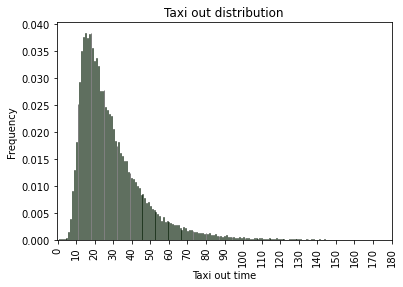

In [15]:
# Plot taxi out time
df_tax = df.groupby(["TAXI_OUT"]).size()
df_tax = df_tax / df_tax.sum()
df_tax.plot.bar(color='green', alpha=0.5, edgecolor='black')
plt.xticks(ticks = np.arange(0, 186, 10), labels = np.arange(0, 186, 10))
plt.title('Taxi out distribution')
plt.xlabel('Taxi out time [minutes]')
plt.ylabel('Frequency');

In the plot above we see the distribution of the variable taxi_out. The distribution looks like a gamma distribution, where most of the observations are in the interval 10-50 mins. However, the tail to the right shows that some flights have a long taxi_out time. This could have influence on the departure delay for the flights. 

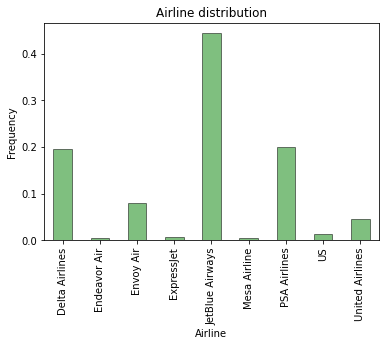

In [16]:
# Get all operators
df_ops = df.filter(regex='OP_CARRIER')
df_ops = df_ops.sum()[1:]

# Get labels
labs = []
lst_idx = list(df_ops.index)
for i in range(len(lst_idx)):
    labs.append(lst_idx[i].replace('OP_CARRIER_', ''))

# Set labels as index
df_ops = df_ops.set_axis(labs)
df_ops = df_ops / sum(df_ops)
df_ops.plot.bar(color='green', alpha=0.5, edgecolor='black')
plt.title('Airline distribution')
plt.xlabel('Airline')
plt.ylabel('Frequency');

The plot above shows the distribution of the different airlines. We see that JetBlue Airways, PSA Airlines and Delta Airlines are the most used airlines in the first six months of 2010. 

C:\Users\jonas\AppData\Local\Temp\ipykernel_204\579655822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delays['DEP_TIME'] = pd.to_datetime(delays.DEP_TIME, format="%H:%M:%S").dt.hour


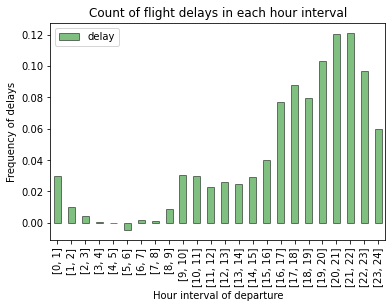

In [17]:
delays = df[['DEP_DELAY', 'DEP_TIME']]
delays['DEP_TIME'] = pd.to_datetime(delays.DEP_TIME, format="%H:%M:%S").dt.hour

# Group by delays
labels = ["[0, 1]", "[1, 2]", "[2, 3]", "[3, 4]", "[4, 5]", "[5, 6]",  "[6, 7]", "[7, 8]", "[8, 9]", "[9, 10]", "[10, 11]", "[11, 12]", "[12, 13]", "[13, 14]", "[14, 15]", "[15, 16]", "[16, 17]", "[17, 18]", "[18, 19]", "[19, 20]", "[20, 21]", "[21, 22]", "[22, 23]", "[23, 24]"] # labels
bins= np.arange(0,25) # intervals
X_dep = delays.copy() # Copy data frame
X_cut = pd.cut(delays['DEP_TIME'], bins=bins, labels=labels, right=False) # cut dataframe
X_dep['dep_group'] = X_cut # Add departure_group

# Create new data frame
cols = ['delay']
df_dep = pd.DataFrame(index=labels, columns=cols)

# take values
values = X_dep.groupby(['dep_group', 'DEP_DELAY']).size()

# Loop
for idx, t in enumerate(labels):
    # Assign total number of delays
    df_dep.delay[idx] = X_dep[X_dep.dep_group == t]['DEP_DELAY'].sum()
    

# Add column and reset index
df_dep['dep_group'] = labels
df_dep = df_dep.reset_index().drop('index', axis=1)

# Plot the data frame in each group
df_dep.set_index('dep_group', inplace=True)
df_dep = df_dep / sum(df_dep.delay)
ax = df_dep.plot.bar(color='green', alpha=0.5, edgecolor='black')
ax.set_xlabel('Hour interval of departure')
ax.set_ylabel('Frequency of delays')
ax.set_title('Count of flight delays in each hour interval');

The plot above shows the flight delays in each hour interval. In the plot we see that few flights are delayed during the night and most of the flights are delayed in during the afternoon and evening. 

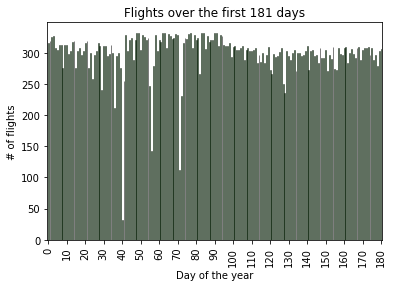

In [18]:
# Plot number of flights for the first six months of 2010
df_date = df.groupby(["FL_DATE"]).size() 
df_date.plot.bar(color='green', alpha=0.5, edgecolor='black')
plt.xticks(ticks = np.arange(0, 181, 10), labels = np.arange(0, 181, 10))
plt.title('Flights over the first 181 days')
plt.xlabel('Day of the year')
plt.ylabel('# of flights');

In the plot above we see how the number of flights are distributed during the time period of the dataset. Overall the distribution is uniform, but there are a few days with a drop in the number of flights. 

(array([5.033e+04, 3.038e+03, 6.390e+02, 1.440e+02, 2.100e+01, 2.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00]),
 array([-23. ,  68.1, 159.2, 250.3, 341.4, 432.5, 523.6, 614.7, 705.8,
        796.9, 888. ]),
 <BarContainer object of 10 artists>)

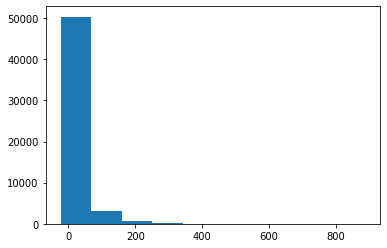

In [19]:
plt.hist(df.DEP_DELAY)